In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# AutoARIMA

In [2]:
# Siccome pmdARIMA è vecchiotto ed è compilato con numpy 1.x, ho downgradato numpy da 2.1 a 1.26
import pmdarima as pm

In [3]:
df = pd.read_csv("airline_passengers.csv", parse_dates=True, index_col="Month")

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df["LogPassengers"] = np.log(df["Passengers"])

In [6]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

## AutoArima sui Passengers

In [7]:
# Trace ci permette di capire quali modelli esplora prima di arrivare al modello migliore
# Warnings soppressi serve per sopprimere i warnings di statsmodels
# A differenza di ARIMA per come la conosciamo, qui indichiamo la stagionalità del modello (che conosciamo da dominio)
model = pm.auto_arima(train["Passengers"], trace=True, suppress_warnings=True, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=0.26 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.10 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=907.049, Time=0.74 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.08 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.16 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.05 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.14 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   :

### Spiegazione del sommario

Prima di tutto, analizziamo qual è stato il modello migliore: un ARIMA (3,0,0)x(0,1,0). Significa che sulla parte non stagionale, si è applicato semplicemente un modello AR(3), sulla parte stagionale una sola time difference.
Troviamo anche alcuni parametri, come AIC (Akake Information Criterion) e BIC (Bayesian Information Criterion) ma anche un HQIC (Hannan–Quinn Information Criterion) e la Negative Log Likelihood minima trovata.

Più in basso troviamo i vari coefficienti trovati, con alcune informazioni statistiche e il risultato di alcuni test di Significatività Statistica.

In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Sun, 25 Aug 2024   AIC                            905.686
Time:                                    18:40:09   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Test
Facciamo un test per valutare se una differenza temporale sul periodo rende la serie stazionaria.
Per farlo, differenziamo a 12 steps (12 mesi) e usiamo il test adfuller

Spoiler: funziona davvero, è stazionaria!

In [9]:
test_df = df["Passengers"].diff(12)

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf(x):
    results = adfuller(x)
    p_value = results[1]
    print(f"Statistic-Test: {results[0]}, p-value: {p_value}")
    if p_value < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

    return

adf(test_df.dropna())

Statistic-Test: -3.383020726492481, p-value: 0.011551493085514954
Series is stationary


<Axes: xlabel='Month'>

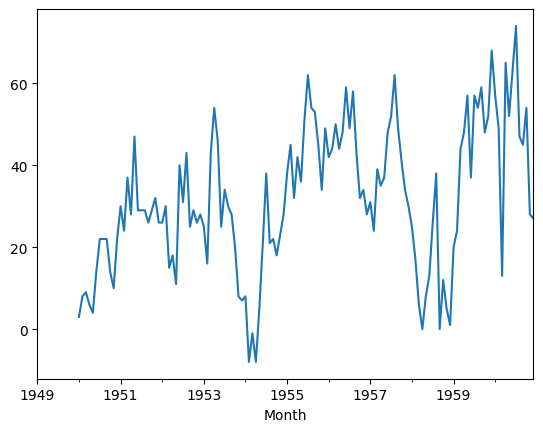

In [11]:
test_df.plot()

### Predizioni con AutoARIMA

In [12]:
def plot_forecast(column, df, train_fit, test_forecast, confint):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(df.index, df[column], label="True Data")
    ax.plot(train_fit.index, train_fit, label="Train Fit")
    ax.plot(test_forecast.index, test_forecast, label="Forecast")
    ax.fill_between(test_forecast.index, confint[:,0], confint[:,1], color="red", alpha=0.3)
    ax.legend();



In [13]:
test_pred, confint = model.predict(n_periods=N_test, return_conf_int=True)
train_pred = model.predict_in_sample(start=0, end=-1)

#### Analisi Plot

Le predizioni sono molto buone. Ovviamente la prima parte è "strana" con delle previsioni a 0. Questo succede perchè abbiamo bisogno di un'intera stagione per poter prevedere l'andamento del modello e fare le previsioni

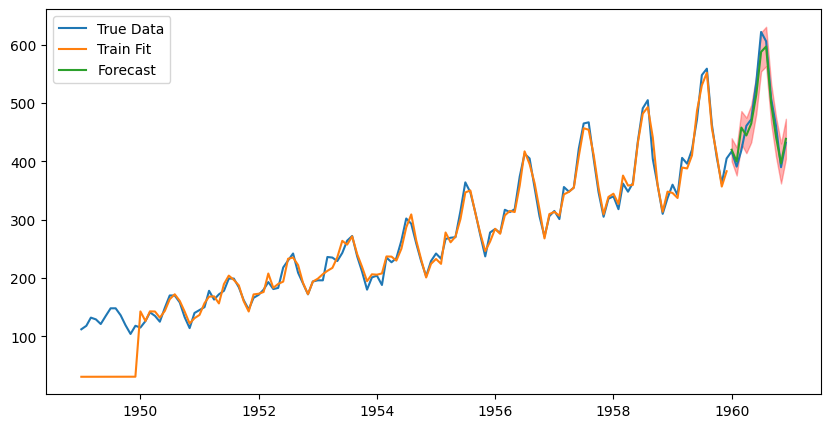

In [14]:
plot_forecast("Passengers", df, train_pred, test_pred, confint)

## AutoArima sul Log Passengers

In [15]:
logmodel = pm.auto_arima(train["LogPassengers"], trace=True, suppress_warnings=True, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-438.248, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-317.949, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-433.027, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-383.189, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-134.983, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-444.325, Time=0.68 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-414.783, Time=0.22 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-442.328, Time=1.23 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-436.714, Time=0.61 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-445.555, Time=0.41 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-414.732, Time=0.24 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-439.800, Time=0.46 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-443.550, Time=0.81 sec
 ARIMA(1,0,2)(1,1,0)[12]

#### Analisi del sommario

Abbiamo creato questo modello per cercare di vedere cosa succede sui LogPassengers, che si sono rivelati in passato essere migliori. Abbiamo trovato un modello leggermente differente: un AR(2) per la parte non stagionale, un MA(1) con TD=1 per quella stagionale

In [16]:
logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 229.026
Date:                              Sun, 25 Aug 2024   AIC                           -448.052
Time:                                      18:40:26   BIC                           -434.114
Sample:                                  01-01-1949   HQIC                          -442.392
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0192      0.009      2.151      0.031       0.002       0.037
ar.L1          0.6003      0.083      7.268      0.000       0.438       0.762
ar.L2          0.2419      0.085      2.854      0.004       0.076       0.408
ma.S.L12      -0.5678      0.105     -5.425      0.000      -0.773      -0.363
sigma2         0.0012      0.000      8.188      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.07
Prob(Q):                              1.00   Prob(JB):                         0.05
Heteroskedasticity (H):               0.36   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
train_pred_log = logmodel.predict_in_sample(start=0, end=-1)
test_pred_log, confint_log = logmodel.predict(n_periods=N_test, return_conf_int=True)

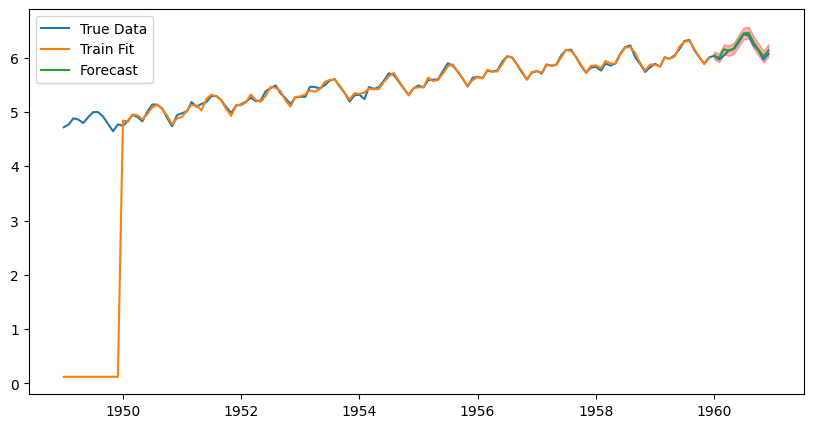

In [18]:
plot_forecast("LogPassengers", df, train_pred_log, test_pred_log, confint_log)

### Forecasting RMSE

In [19]:
def rmse(y, t):
    return np.sqrt(np.mean((y-t)**2))

In [20]:
print(f"Non Logged RMSE: {rmse(test["Passengers"], test_pred)}")
print(f"Logged RMSE: {rmse(test["Passengers"], np.exp(test_pred_log))}")

Non Logged RMSE: 18.53646898251707
Logged RMSE: 23.05722199319103


## Giochiamo con AutoArima e la ricerca dei parametri

Usiamo i LogPassengers per fare la scansione dei parametri secondo il metodo stepwise.
AutoArima setta i parametri massimi ad un valore basso, dobbiamo alzare noi per trovare dei modelli migliori.
Max_Order è un parametro speciale: limita la somma degli ordini di ARIMA ad essere massimo il valore impostato ed aiuta a trovare valori più semplici.

Il motivo per cui settiamo seasonal a false è valutare la bontà di autoarima comparato al vecchio script dove non guardavamo la stagionalità.

In [27]:
# Per provare una full grid, settare stepwise=False, altrimenti per usare l'algoritmo intelligente usare True
toy_model = pm.auto_arima(train["LogPassengers"], trace=True, suppress_warnings=True, max_p=12, max_q=2, max_order=14, \
                          stepwise=False, seasonal=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-211.983, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-216.493, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-214.718, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-221.069, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-216.622, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-240.134, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-216.024, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-246.260, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-246.403, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-229.057, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-227.139, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-250.908, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0] i

In [28]:
toy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:              SARIMAX(12, 1, 1)   Log Likelihood                 227.153
Date:                Sun, 25 Aug 2024   AIC                           -424.306
Time:                        18:42:26   BIC                           -381.178
Sample:                    01-01-1949   HQIC                          -406.781
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0078      0.006      1.306      0.192      -0.004       0.019
ar.L1          0.0281      0.092      0.304      0.761      -0.153       0.209
ar.L2         -0.0876      0.069     -1.279      0.201      -0.222       0.047
ar.L3         -0.0381      0.068     -0.564      0.573      -0.171       0.094
ar.L4         -0.1168      0.073     -1.604      0.109      -0.259       0.026
ar.L5          0.0018      0.067      0.027      0.978      -0.129       0.133
ar.L6         -0.0693      0.067     -1.036      0.300      -0.201       0.062
ar.L7         -0.0499      0.073     -0.684      0.494      -0.193       0.093
ar.L8         -0.1263      0.067     -1.884      0.060      -0.258       0.005
ar.L9         -0.0032      0.080     -0.040      0.968      -0.159       0.153
ar.L10        -0.0866      0.066     -1.315      0.188      -0.216       0.042
ar.L11         0.0070      0.073      0.096      0.923      -0.135       0.149
ar.L12         0.7723      0.064     12.115      0.000       0.647       0.897
ma.L1         -0.3659      0.129     -2.837      0.005      -0.619      -0.113
sigma2         0.0016      0.000      7.094      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.96   Prob(JB):                         0.31
Heteroskedasticity (H):               0.37   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
train_pred_toy = toy_model.predict_in_sample(start=1, end=-1)
test_pred_toy, confint_toy = toy_model.predict(n_periods=N_test, return_conf_int=True)

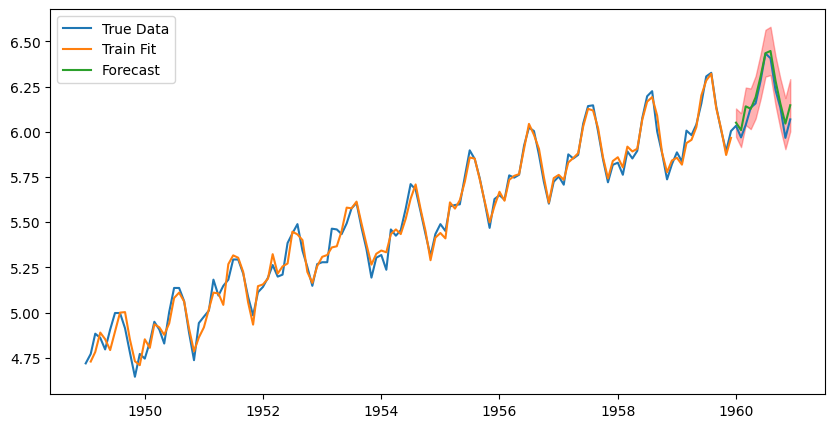

In [30]:
plot_forecast("LogPassengers", df, train_pred_toy, test_pred_toy, confint_toy)

In [31]:
print(f"Toy RMSE: {rmse(test["Passengers"], np.exp(test_pred_toy))}")

Toy RMSE: 23.33886147291245
